# Planar 2D-2D Geometry (Projective Geometry)

Planar Homography Estimation
- Unknown: <font color='red'>Planar homograph (8 DoF)</font>
- Given: Point correspondences ($x_1$, $x'_1$), ..., ($x_n$, $x'_n$).
- Constraints: $n$ projective transformations $x'_i = Hx_i$
- Solutions ($n\ge4$)-> 4-point algorithm
  * More simplied transformations need less number of minimal correspondences. For instance, Affine ($n\ge3$), similarity ($n\ge2$), Euclidean ($n\ge2$).

In [13]:
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

## General 2D-2D Geometry (Epipolar Geometry)

### Essential Matrix Estimation
* Unknown: <font color='red'>Essential matrix (5 DoF)</font>
* Given: Point correspondences on the normalized image plane ($\hat{x}_1$, $\hat{x}'_1$), ..., ($\hat{x}_n$, $\hat{x}'_n$)
* Constraints: $n$ epipolar constraints: $\hat{x}'_i E \hat{x}_i=0$.
* Solutions: 5-point algorithm

### Fundamental Matrix Estimation
* Unknown: <font color='red'>Fundamental matrix (7 DoF)</font>
* Given: Point correspondences on the image plane ($x_1$, $x'_1$), ..., ($x_n$, $x'_n$)
* Constraints: $n$ epipolar constraints: $x'_i F x_i=0$.
* Solutions: 7/8-point algorithm

### Relationship between Essential matrix and Fundamental matrix

\begin{eqnarray}
x'^\top_i F x_i &= 0 \\
\hat{x}'^\top_i K'^\top \cdot F \cdot K \hat{x}_i &= 0 \\
\hat{x}'^\top_i E \hat{x}_i &= 0
\end{eqnarray}

Thus we have the following relation between Fundamental matrix $F$ and Essential matrix $E$

\begin{equation}
E = K'^\top F K
\end{equation}

where $x_i$ is a point on the image plane whereas $\hat{x}'_i$ is a point on the normalized image plane. Thus we have
\begin{eqnarray}
x_i &= K \hat{x}_i \\
x'_i &= K' \hat{x}'_i
\end{eqnarray}

### Relative Camera Pose Estimation

TBD

### Fundamental Matrix Estimation

In [3]:
def findFundamentalMat(pts1, pts2):
  if len(pts1) == len(pts2):
      # Make homogeneous coordiates if necessary
      if pts1.shape[1] == 2:
          pts1 = np.hstack((pts1, np.ones((len(pts1), 1), dtype=pts1.dtype)))
      if pts2.shape[1] == 2:
          pts2 = np.hstack((pts2, np.ones((len(pts2), 1), dtype=pts2.dtype)))

      # Solve 'Ax = 0'
      A = []
      for p, q in zip(pts1, pts2):
          A.append([q[0]*p[0], q[0]*p[1], q[0]*p[2], q[1]*p[0], q[1]*p[1], q[1]*p[2], q[2]*p[0], q[2]*p[1], q[2]*p[2]])
      _, _, Vt = np.linalg.svd(A, full_matrices=True)
      x = Vt[-1]

      # Reorganize 'F' and enforce 'rank(F) = 2'
      F = x.reshape(3, -1)
      U, S, Vt = np.linalg.svd(F)
      S[-1] = 0
      F = U @ np.diag(S) @ Vt
      return F / F[-1,-1] # Normalize the last element as 1

In [12]:
# This example is not working properly.
pts0 = np.loadtxt('image_formation0.xyz')
pts1 = np.loadtxt('image_formation1.xyz')

my_F = findFundamentalMat(pts0, pts1)
cv_F, _ = cv2.findFundamentalMat(pts0, pts1, cv2.FM_8POINT)

print('\n### My Fundamental Matrix')
print(my_F)
print('\n### OpenCV Fundamental Matrix')
print(cv_F) # Note) The result is slightly different because OpenCV considered normalization


### My Fundamental Matrix
[[ 9.58338760e-07 -3.90401514e-06  2.63989232e-03]
 [ 2.23061767e-06  6.92824550e-06 -6.48674644e-03]
 [-4.52814541e-03  1.36351081e-03  1.00000000e+00]]

### OpenCV Fundamental Matrix
[[ 1.74112973e-05 -1.90730866e-05  6.23986061e-02]
 [ 1.82536639e-05 -1.65112875e-05 -6.94722451e-02]
 [-7.12457989e-02  7.14240132e-02  1.00000000e+00]]


### Scale Ambiguity

### Visual Odometry

In [131]:
def plot_camera(R, t, w, h, f, scale=0.0001):
  V = np.array([[0, 0, 0, f, -w/2,  w/2, w/2, -w/2],
                [0, 0, f, 0, -h/2, -h/2, h/2,  h/2],
                [0, f, 0, 0,  f,    f,   f,    f]])
  V *= scale
  V = R.T @ (V - t.reshape((3, 1)))

  plt.plot(V[0, [0, 3]], V[1, [0, 3]], zs=V[2, [0, 3]], color='r') # x-axis
  plt.plot(V[0, [0, 2]], V[1, [0, 2]], zs=V[2, [0, 2]], color='g') # y-axis
  plt.plot(V[0, [0, 1]], V[1, [0, 1]], zs=V[2, [0, 1]], color='b') # z-axis

  plt.plot(V[0, [0, 4]], V[1, [0, 4]], V[2, [0, 4]], color='k')
  plt.plot(V[0, [0, 5]], V[1, [0, 5]], V[2, [0, 5]], color='k')
  plt.plot(V[0, [0, 6]], V[1, [0, 6]], V[2, [0, 6]], color='k')
  plt.plot(V[0, [0, 7]], V[1, [0, 7]], V[2, [0, 7]], color='k')

  plt.plot(V[0, [4,5,6,7,4]], V[1, [4,5,6,7,4]], V[2, [4,5,6,7,4]], color='k')

In [58]:
from signal import raise_signal
import cv2
import numpy as np
import glob

input = "%06d.png"
f = 707.0912
c = (601.8873, 183.1104)
use_5pt = True
min_inlier_num = 100

# Open a file to write camera trajectory
# my_file = "../bin/data/vo_epipolar_v2.xyz"
# camera_trajectory = open(my_file, 'wt')
# if camera_trajectory == 0: raise Exception("Can't make file")

# Open a video and get initial image
cap = cv2.VideoCapture(input)
if cap.isOpened() == False: raise Exception("Cant read images")

_, image = cap.read()
gray_prev = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

camera_pose = np.eye(4, dtype=np.float64)

count = 1
images = [image]
camera_poses = [camera_pose]
while cap.isOpened():
  ret, image = cap.read()
  if ret == False: break
  if image.shape[2] == 3: gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  point_prev = cv2.goodFeaturesToTrack(gray_prev, 2000, 0.01, 10)

  point, status, err = cv2.calcOpticalFlowPyrLK(gray_prev, gray, point_prev, None)
  gray_prev = gray

  if use_5pt:
      E, inliner_mask = cv2.findEssentialMat(point_prev, point, f, c, cv2.FM_RANSAC, 0.99, 1)
  else:
      F, inliner_mask = cv2.findFundamentalMat(point_prev, point, cv2.FM_RANSAC, 1, 0.99)
      K = np.array([[f, 0, c[0]], [0,f,c[1]], [0,0,1]])
      E = K.T @ F @ K

  inlier_num, R, t, mask = cv2.recoverPose(E, point, point_prev)

  if inlier_num > min_inlier_num:
      T = np.eye(4)
      T[0:3, 0:3] = R * 1.0
      T[0:3,[3]] = t* 1.0
      # T[0:3, 0:3] = R.T
      # T[0:3, [3]] = R.T @ t
      camera_pose = camera_pose @ np.linalg.inv(T)
      # camera_pose = np.linalg.inv(T)

  # Show the image and write camera pose
  if image.shape[2] < 3: image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

  # for i in range(len(point_prev)):
  #     px_prev, py_prev = point_prev[i][0][0], point_prev[i][0][1]
  #     px, py = point[i][0][0], point[i][0][1]
  #     if inliner_mask[i] > 0: image = cv2.line(image, (px_prev, py_prev), (px, py), (0,0,255))
  #     else: image = cv2.line(image, (px_prev, py_prev), (px, py), (0,127,0))

  info = f"Inliers: {inlier_num} ({100*inlier_num/len(point)}), XYZ: [{camera_pose[0][2]:.3f} {camera_pose[1][2]:.3f} {camera_pose[2][2]:.3f}]"
  # camera_trajectory.write(f"{camera_pose[0][2]:.6f} {camera_pose[0][2]:.6f} {camera_pose[0][2]:.6f}\n")
  cv2.putText(image, info, (5,15), cv2.FONT_HERSHEY_PLAIN, 1, (0,255,0))
  # cv2.imshow("test", image)
  # key = cv2.waitKey(1)
  # if key == ord('q'): break

  camera_poses.append(camera_pose)

  if count % 10:
    images.append(image)
  count += 1

cap.release()
# camera_trajectory.close()

# plot images
# if not len(images): raise Exception("No images")
# ncols = 3
# nrows = math.ceil(len(images) / ncols)
# f, ax = plt.subplots(nrows, figsize=[200, 60])
# for i in range(nrows):
#   vis_image = np.hstack((images[i*ncols:(i+1)*ncols]))
#   ax[i].imshow(vis_image[:, :, (2, 1, 0)])
#   ax[i].axis('off')
# plt.show()

# plot camera poses
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(-90, 0)
for i in range(len(camera_poses)):
  plot_camera(camera_poses[i][0:3,0:3], camera_poses[i][0:3,3], c[0], c[1], f)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

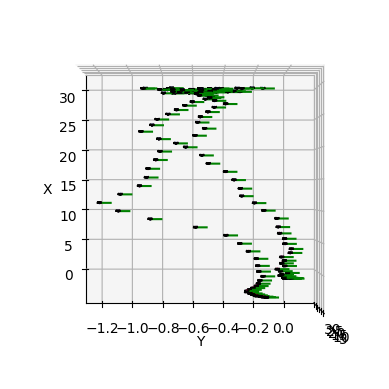

In [136]:
# camera_poses[0]
i = 0
# R = camera_poses[i][0:3,0:3]
# t=camera_poses[i][0:3, 3]
# w=c[0]
# h=c[1]
# f
# V = R.T @ (V - t.reshape((3, 1)))
# V
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.view_init(-90, 0)
for i in range(159):
  plot_camera(camera_poses[i][0:3,0:3], camera_poses[i][0:3,3], c[0], c[1], f)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

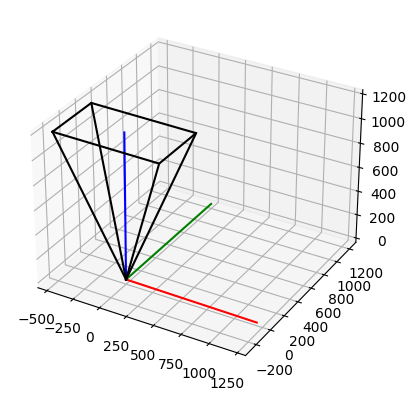

In [84]:
fig = plt.figure()
ax = plt.axes(projection='3d')
# f, w, h = 1200, 960, 480
# V = np.array([[0, 0, 0, f, -w/2,  w/2, w/2, -w/2],
#                [0, 0, f, 0, -h/2, -h/2, h/2,  h/2],
#                [0, f, 0, 0,  f,    f,   f,    f]])
# V[0, [0, 3]]
plt.plot(V[0, [0, 3]], V[1, [0, 3]], zs=V[2, [0, 3]], color='r')
plt.plot(V[0, [0, 2]], V[1, [0, 2]], zs=V[2, [0, 2]], color='g')
plt.plot(V[0, [0, 1]], V[1, [0, 1]], zs=V[2, [0, 1]], color='b')

plt.plot(V[0, [0, 4]], V[1, [0, 4]], V[2, [0, 4]], color='k')
plt.plot(V[0, [0, 5]], V[1, [0, 5]], V[2, [0, 5]], color='k')
plt.plot(V[0, [0, 6]], V[1, [0, 6]], V[2, [0, 6]], color='k')
plt.plot(V[0, [0, 7]], V[1, [0, 7]], V[2, [0, 7]], color='k')

plt.plot(V[0, [4,5,6,7,4]], V[1, [4,5,6,7,4]], V[2, [4,5,6,7,4]], color='k')

### Triangulation